In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import copy

### Part 2:  Pose Graph Optimization for 2D SLAM

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

### Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

# Helper Code

## From examples/g2o.ipynb

In [1]:
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readAdjEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

        if("FIX 0" in line):
            break

    return [ind1_arr, ind2_arr, del_x, del_y, del_theta]

def readPointClosures(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    flag = False

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if("EDGE_SE2" in line and flag):
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

        if("FIX 0" in line):
            flag = not(flag)

    return [ind1_arr, ind2_arr, del_x, del_y, del_theta]

## From examples/Helper Code.ipynb

In [2]:
colors = {"Ground Truth":'ro', "Current Estimate":'bo', "Initial Estimate":'go'}

def draw(X, Y, THETA, label="Ground Truth"):
    ax = plt.subplot(111)
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
    plt.plot(X, Y, 'c-')
    ax.plot(X, Y, colors[label], label=label)

# Generate the Initial Estimate

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(5, 139)


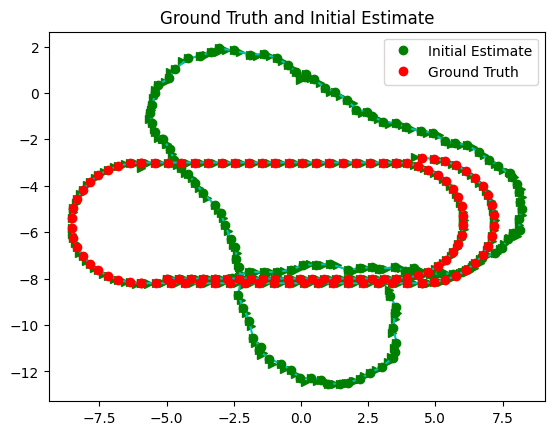

In [5]:
vals = readAdjEdge("../data/edges.txt")
vert = readVertex("../data/edges.txt")

X = [vert[0][0]]
Y = [vert[1][0]]
THETA = [vert[2][0]]
x = X[0]
y = Y[0]
theta = THETA[0]

poses = []
poses.append(jnp.array([x, y, theta]))

for i in range(len(vals[2])):
    X.append(0)
    Y.append(0)
    THETA.append(0)

for i in range(len(vals[0])):
    # if abs(vals[1][i] - vals[0][i]) > 1:
    #     break
    X[vals[1][i]] = X[vals[0][i]] + (vals[2][i]*math.cos(THETA[vals[0][i]]) - vals[3][i]*math.sin(THETA[vals[0][i]]))
    Y[vals[1][i]] = Y[vals[0][i]] + (vals[3][i]*math.cos(THETA[vals[0][i]]) + vals[2][i]*math.sin(THETA[vals[0][i]]))
    THETA[vals[1][i]] = THETA[vals[0][i]] + vals[-1][i]
    x = X[vals[1][i]]
    y = Y[vals[1][i]]
    theta = THETA[vals[1][i]]
    poses.append(jnp.array([x, y, theta]))

plt.title("Noisy Data")
poses = jnp.array(poses)
anchor = jnp.array(poses[0, :])
loopClosures = readPointClosures("../data/edges.txt")
vals[0].extend(loopClosures[0])
vals[1].extend(loopClosures[1])
vals[2].extend(loopClosures[2])
vals[3].extend(loopClosures[3])
vals[4].extend(loopClosures[4])
vals = jnp.array(vals)
print(vals.shape)

draw(X, Y, THETA, label="Initial Estimate")

actVals = readVertex("../data/gt.txt")
plt.title("Ground Truth and Initial Estimate")
draw(actVals[0], actVals[1], actVals[2], label="Ground Truth")

plt.legend()
plt.show()

### Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this assignment. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [5]:
weight_odometry = 10
weight_loop_closure = 1000
weight_anchor = 1200

def compute_information_matrix(edges, weight_odometry, weight_loop_closure, weight_anchor):
    information_diagonal = []  

    anchor_weights = [weight_anchor] * 3
    information_diagonal += anchor_weights

    for i in range(edges[0].shape[0]):
        pose_index_1 = int(edges[0][i]) 
        pose_index_2 = int(edges[1][i]) 

        if abs(pose_index_2 - pose_index_1) == 1:
            odom_weights = [weight_odometry] * 3
            information_diagonal += odom_weights
        else:
            loop_weights = [weight_loop_closure] * 3
            information_diagonal += loop_weights

    information_matrix = jnp.diag(jnp.array(information_diagonal))
    return information_matrix

def update_pose(x, y, theta, del_x, del_y, del_theta):
    x = x + (del_x * jnp.cos(theta) - del_y * jnp.sin(theta))
    y = y + (del_x * jnp.sin(theta) + del_y * jnp.cos(theta))
    theta = theta + del_theta
    return x, y, theta

def residual(poses, edges, anchor):
    residues = []

    anchor_residue = poses[0] - anchor
    residues.extend(anchor_residue)

    for i in range(edges[0].shape[0]):
        pose_index_1 = int(edges[0][i])  
        pose_index_2 = int(edges[1][i]) 

        del_x, del_y, del_theta = edges[2][i], edges[3][i], edges[4][i]
        curr_x = poses[pose_index_1][0]
        curr_y = poses[pose_index_1][1]
        curr_theta = poses[pose_index_1][2]

        upd_x, upd_y, upd_theta = update_pose(curr_x, curr_y, curr_theta, del_x, del_y, del_theta)
        updated_pose = jnp.array([upd_x, upd_y, upd_theta])
        
        edge_residue = updated_pose - poses[pose_index_2]
        residues.extend(edge_residue)

    return jnp.asarray(residues)

def error_func(poses, edges, anchor, information_matrix):
    residues = residual(poses, edges, anchor)
    error = 0.5 * jnp.dot(jnp.dot(residues.T, information_matrix), residues)
    return error

def compute_derivative_matrix(del_x, del_y, theta):
    derivative_matrix = jnp.eye(3)
    derivative_matrix = derivative_matrix.at[(0, 2)].set(-del_x * jnp.sin(theta) - del_y * jnp.cos(theta))
    derivative_matrix = derivative_matrix.at[(1, 2)].set(-del_y * jnp.sin(theta) + del_x * jnp.cos(theta))
    
    return derivative_matrix

def compute_jacobian(poses, edges):
    num_constraints = (edges[0].shape[0] * 3) + 3 
    num_variables = poses.shape[0] * 3 

    J = jnp.zeros((num_constraints, num_variables))
    J = J.at[:3, :3].set(jnp.eye(3))

    for i in range(edges[0].shape[0]):
        pose_index_1 = int(edges[0][i])  
        pose_index_2 = int(edges[1][i]) 
        del_x = edges[2][i] 
        del_y = edges[3][i]  

        J = J.at[3 + i*3:3 + i*3 + 3, pose_index_1*3: pose_index_1*3 + 3].set(compute_derivative_matrix(del_x, del_y, poses[pose_index_1][2]))
        I = -1 * jnp.eye(3)
        J = J.at[3 + i*3:3 + i*3 + 3, pose_index_2*3: pose_index_2*3 + 3].set(I)
    return J

def calc_step(poses, edges, weights, alpha, anchor):
    resid = residual(poses, edges, anchor)
    J = compute_jacobian(poses, edges)

    step = (-jnp.linalg.inv(J.T @ weights @ J + alpha * jnp.eye(J.shape[1])) @ J.T @ weights.T @ resid)

    return step.reshape((-1,3))

### Jax Jacobian

(420, 360)
(420, 360)
Frobenius norm b.w inbuilt jacobian and our jacobian is:  0.0


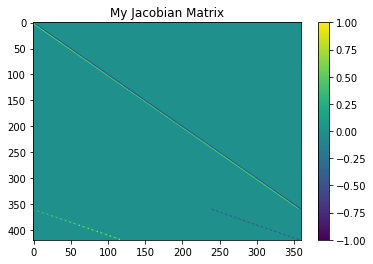

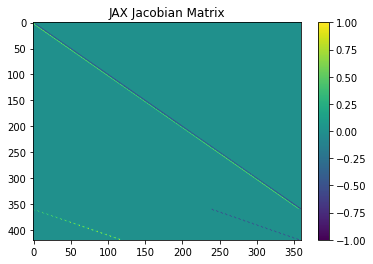

In [6]:
jacob_fn = jax.jacfwd(residual, argnums=0)
jaxJacob = jacob_fn(poses, vals, anchor)
jaxJacob = jaxJacob.reshape((420, -1, 1))
jaxJacob = jaxJacob[:, :, 0]

print(jaxJacob.shape)
myJacob = compute_jacobian(poses, vals)
print(myJacob.shape)

def frobNorm(P1, P2):
    return jnp.linalg.norm(P1 - P2, 'fro')

frobenius_norm = frobNorm(jaxJacob, myJacob)
print("Frobenius norm b.w inbuilt jacobian and our jacobian is: ", frobenius_norm)

plt.imshow(myJacob, cmap='viridis', aspect='auto')
plt.title("My Jacobian Matrix")
plt.colorbar()
plt.show()

plt.imshow(jaxJacob, cmap='viridis', aspect='auto')
plt.title("JAX Jacobian Matrix")
plt.colorbar()
plt.show()

### Optimization

Alpha is 1
Initial
Error: 913388.6


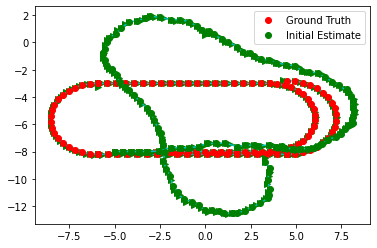

Iteration: 2
Alpha: 1
Error: 160258.84


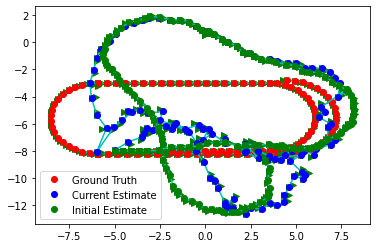

Iteration: 3
Alpha: 0.5
Error: 469.65894


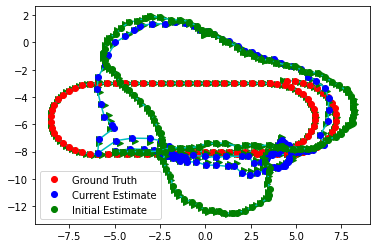

Iteration: 4
Alpha: 0.25
Error: 362.45602


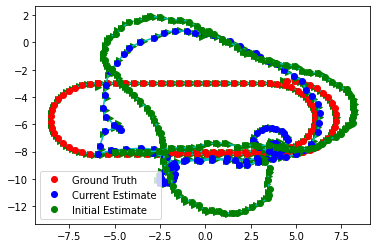

Iteration: 5
Alpha: 0.125
Error: 81.32958


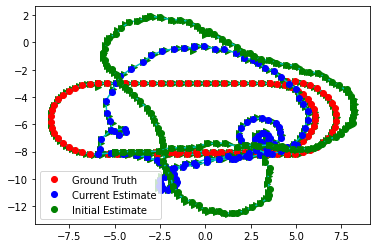

Iteration: 6
Alpha: 0.0625
Error: 65.310524


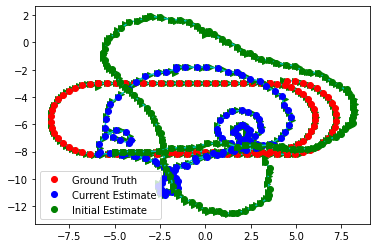

Iteration: 7
Alpha: 0.03125
Error: 56.032906


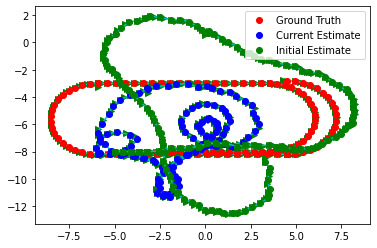

Iteration: 8
Alpha: 0.015625
Error: 63.929996


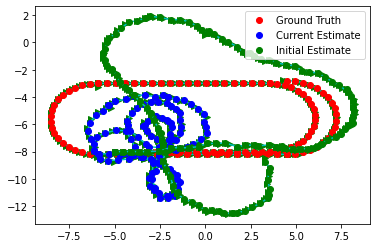

Iteration: 9
Alpha: 0.03125
Error: 37.156628


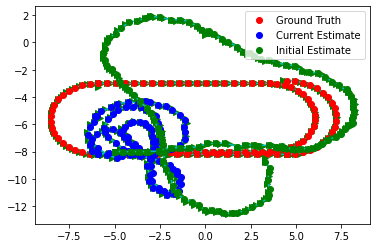

Iteration: 10
Alpha: 0.015625
Error: 48.304558


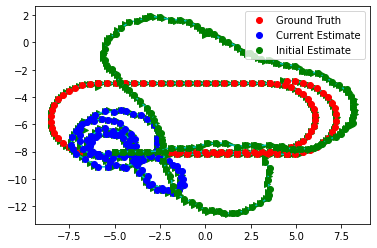

Iteration: 11
Alpha: 0.03125
Error: 29.833143


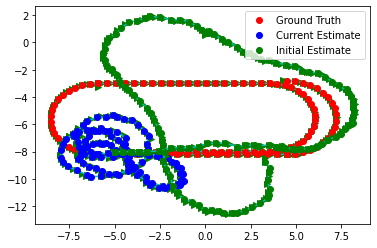

Iteration: 12
Alpha: 0.015625
Error: 34.254086


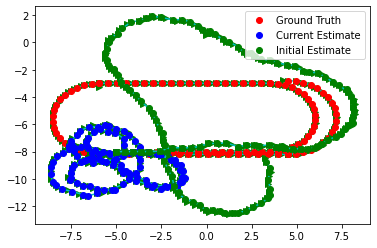

Iteration: 13
Alpha: 0.03125
Error: 25.722286


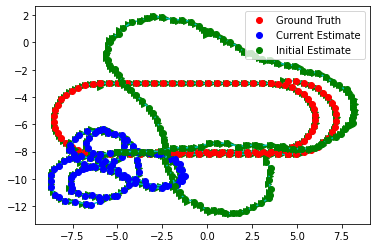

Iteration: 14
Alpha: 0.015625
Error: 28.012491


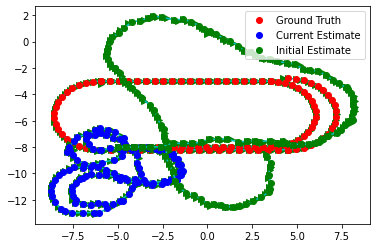

Iteration: 15
Alpha: 0.03125
Error: 23.188349


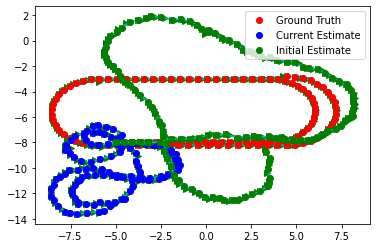

Iteration: 16
Alpha: 0.015625
Error: 24.694206


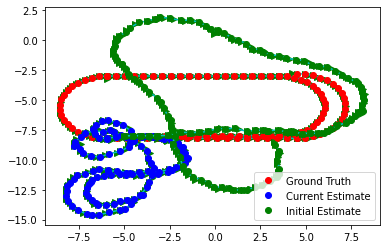

Iteration: 17
Alpha: 0.03125
Error: 21.31417


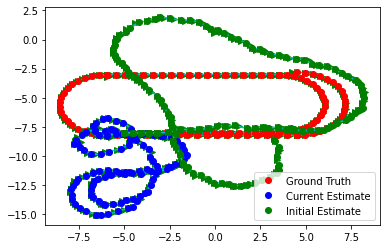

Iteration: 18
Alpha: 0.015625
Error: 22.26672


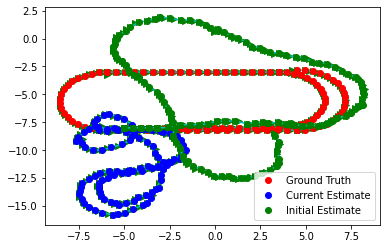

Iteration: 19
Alpha: 0.0078125
Error: 28.781672


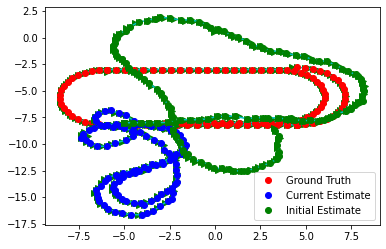

Iteration: 20
Alpha: 0.015625
Error: 19.541174


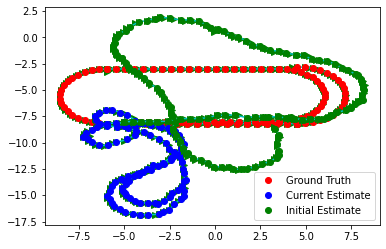

Iteration: 21
Alpha: 0.0078125
Error: 23.217377


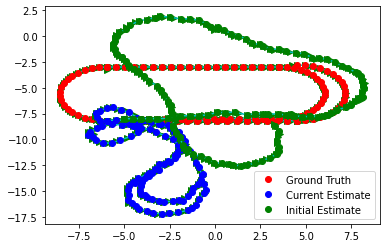

Iteration: 22
Alpha: 0.015625
Error: 17.4684


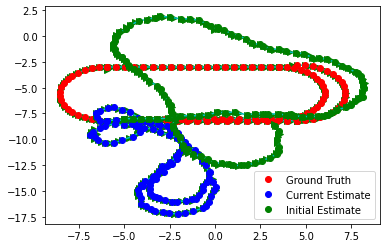

Iteration: 23
Alpha: 0.0078125
Error: 19.188578


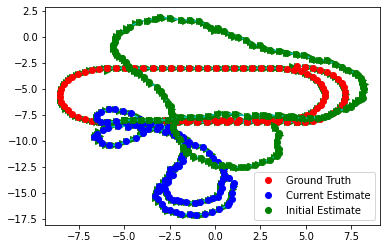

Iteration: 24
Alpha: 0.015625
Error: 15.990994


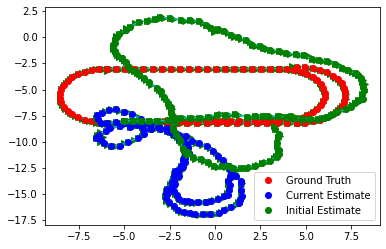

Iteration: 25
Alpha: 0.0078125
Error: 16.699415


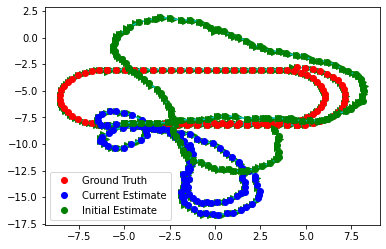

Iteration: 26
Alpha: 0.00390625
Error: 21.183403


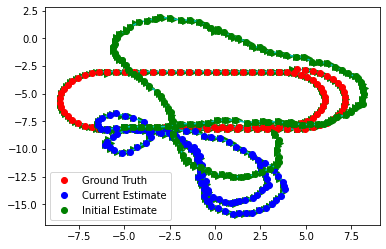

Iteration: 27
Alpha: 0.0078125
Error: 14.455222


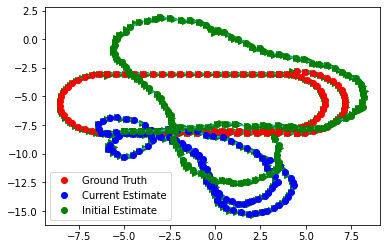

Iteration: 28
Alpha: 0.00390625
Error: 16.62245


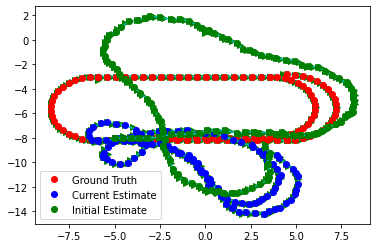

Iteration: 29
Alpha: 0.0078125
Error: 13.012384


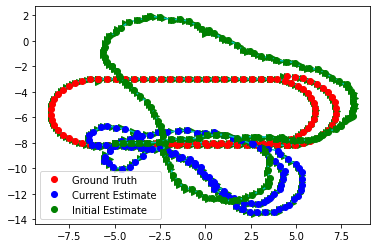

Iteration: 30
Alpha: 0.00390625
Error: 13.907315


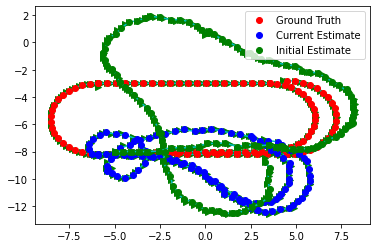

Iteration: 31
Alpha: 0.001953125
Error: 17.334885


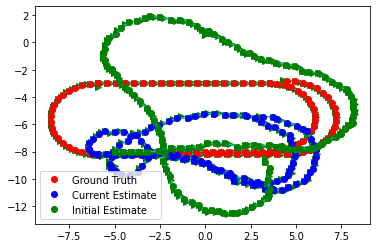

Iteration: 32
Alpha: 0.00390625
Error: 11.628059


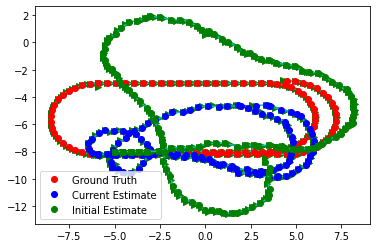

Iteration: 33
Alpha: 0.001953125
Error: 12.817814


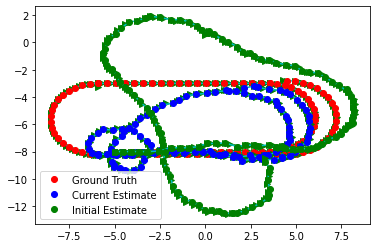

Iteration: 34
Alpha: 0.00390625
Error: 10.664846


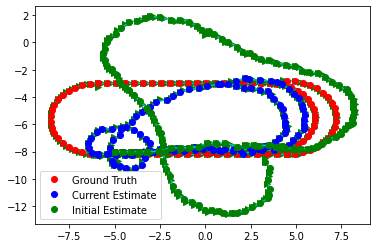

Iteration: 35
Alpha: 0.001953125
Error: 10.930595


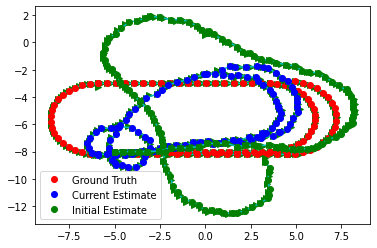

Iteration: 36
Alpha: 0.0009765625
Error: 11.109849


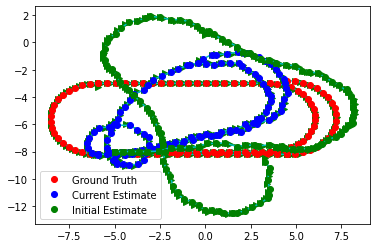

Iteration: 37
Alpha: 0.00048828125
Error: 10.652375


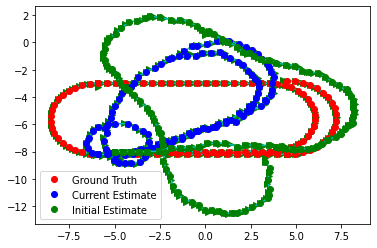

Iteration: 38
Alpha: 0.000244140625
Error: 10.074435


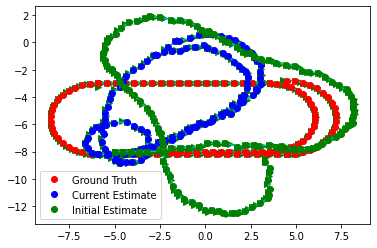

Iteration: 39
Alpha: 0.0001220703125
Error: 9.789285


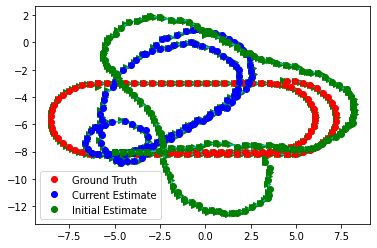

Iteration: 40
Alpha: 6.103515625e-05
Error: 9.700629


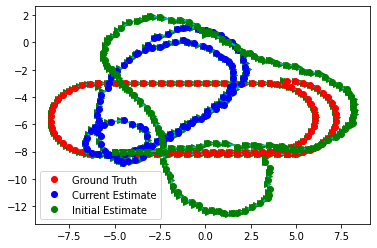

Iteration: 41
Alpha: 3.0517578125e-05
Error: 9.676065


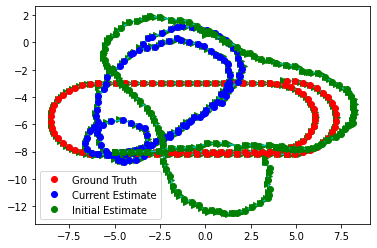

Iteration: 42
Alpha: 1.52587890625e-05
Error: 9.668752


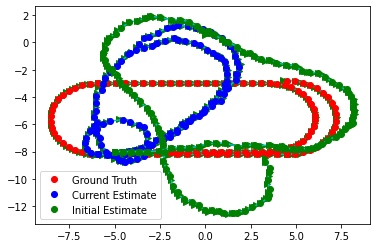

Iteration: 43
Alpha: 7.62939453125e-06
Error: 9.66638


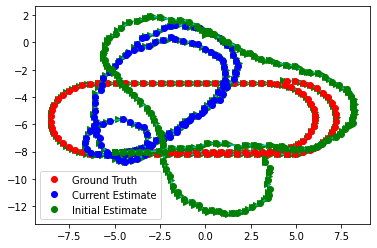

Iteration: 44
Alpha: 3.814697265625e-06
Error: 9.665491


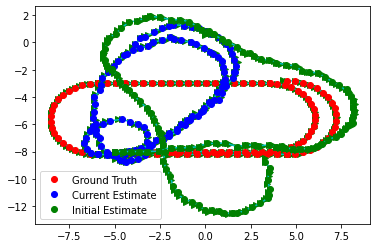

Iteration: 45
Alpha: 1.9073486328125e-06
Error: 9.665133


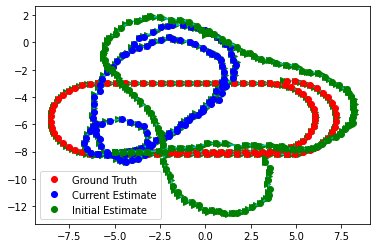

Iteration: 46
Alpha: 9.5367431640625e-07
Error: 9.66498


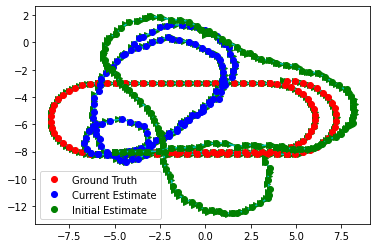

Iteration: 47
Alpha: 4.76837158203125e-07
Error: 9.664912


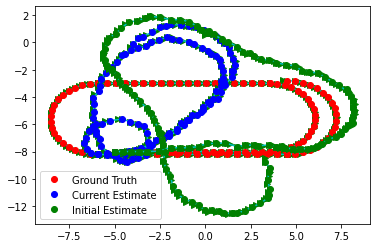

Iteration: 48
Alpha: 2.384185791015625e-07
Error: 9.664881


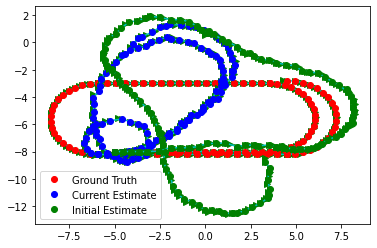

Iteration: 49
Alpha: 1.1920928955078125e-07
Error: 9.664865


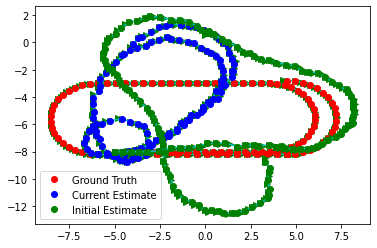

Iteration: 50
Alpha: 5.960464477539063e-08
Error: 9.664863


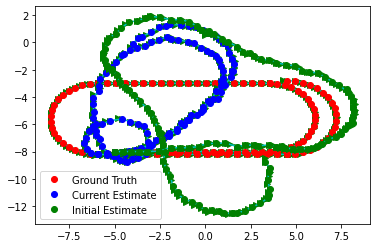

Iteration: 51
Alpha: 2.9802322387695312e-08
Error: 9.664855


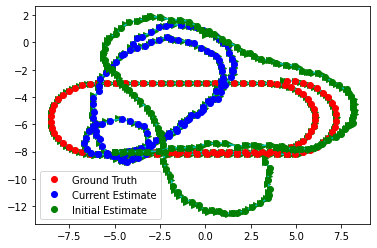

Iteration: 52
Alpha: 1.4901161193847656e-08
Error: 9.6648655


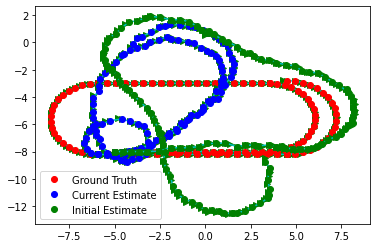

Iteration: 53
Alpha: 7.450580596923828e-09
Error: 9.664859


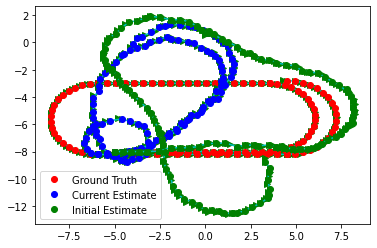

Iteration: 54
Alpha: 3.725290298461914e-09
Error: 9.664861


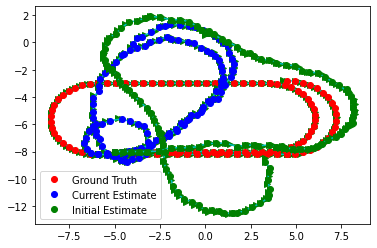

Iteration: 55
Alpha: 1.862645149230957e-09
Error: 9.664855


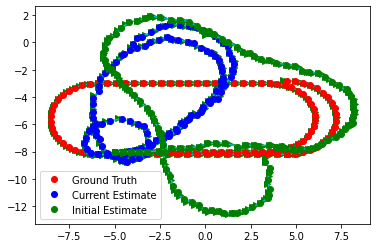

Iteration: 56
Alpha: 9.313225746154785e-10
Error: 9.664859


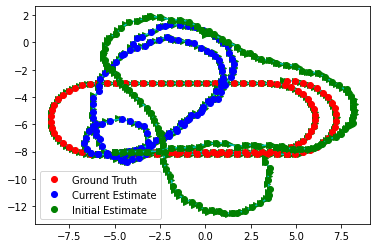

Iteration: 57
Alpha: 4.656612873077393e-10
Error: 9.664861


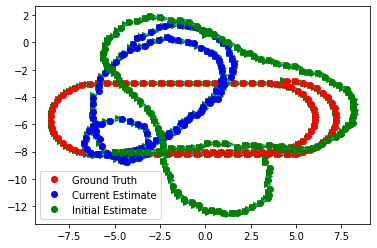

Iteration: 58
Alpha: 2.3283064365386963e-10
Error: 9.66486


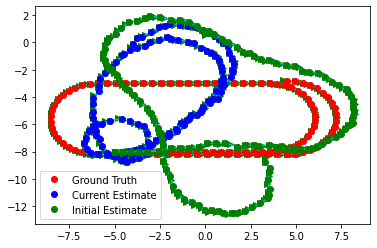

Iteration: 59
Alpha: 1.1641532182693481e-10
Error: 9.664858


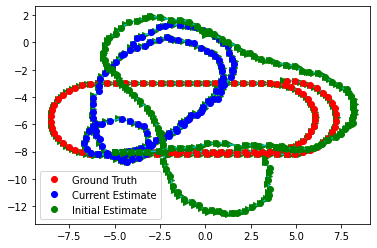

Iteration: 60
Alpha: 5.820766091346741e-11
Error: 9.664857


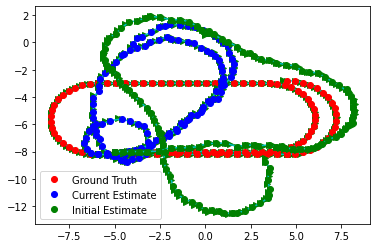

Iteration: 61
Alpha: 2.9103830456733704e-11
Error: 9.664861


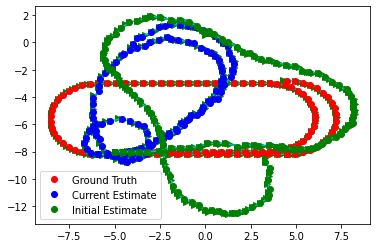

Iteration: 62
Alpha: 1.4551915228366852e-11
Error: 9.66486


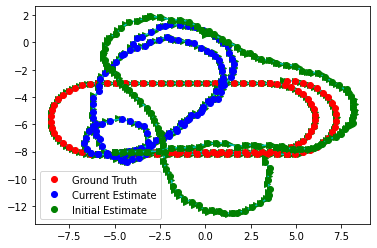

Iteration: 63
Alpha: 7.275957614183426e-12
Error: 9.664858


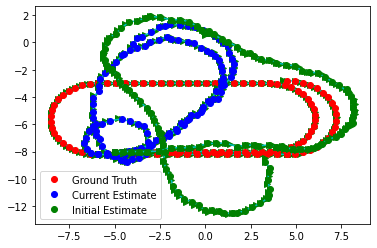

Iteration: 64
Alpha: 3.637978807091713e-12
Error: 9.664857


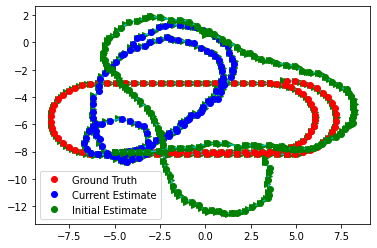

Iteration: 65
Alpha: 1.8189894035458565e-12
Error: 9.664852


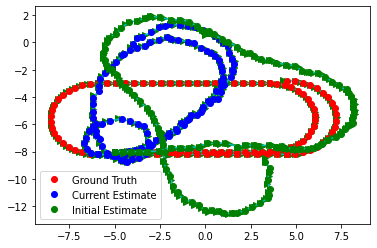

Iteration: 66
Alpha: 9.094947017729282e-13
Error: 9.664856


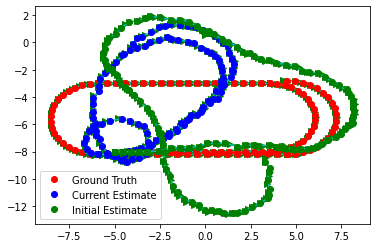

Iteration: 67
Alpha: 4.547473508864641e-13
Error: 9.664854


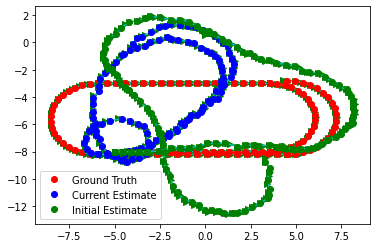

Iteration: 68
Alpha: 2.2737367544323206e-13
Error: 9.664856


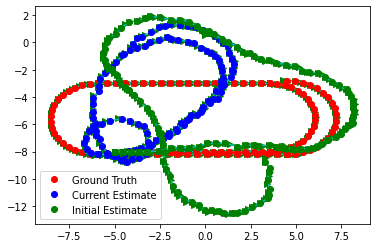

Iteration: 69
Alpha: 1.1368683772161603e-13
Error: 9.664856


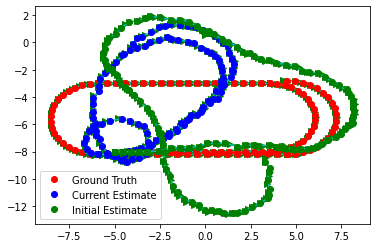

Iteration: 70
Alpha: 5.684341886080802e-14
Error: 9.664855


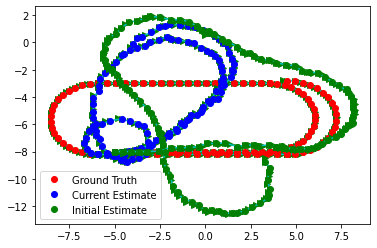

Iteration: 71
Alpha: 2.842170943040401e-14
Error: 9.664852


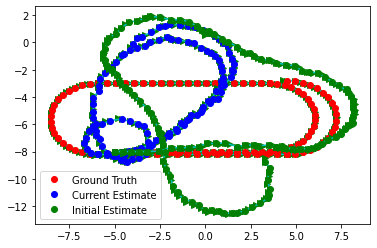

Iteration: 72
Alpha: 1.4210854715202004e-14
Error: 9.664853


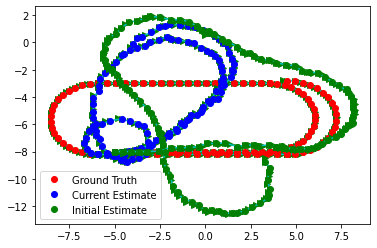

Iteration: 73
Alpha: 7.105427357601002e-15
Error: 9.664863


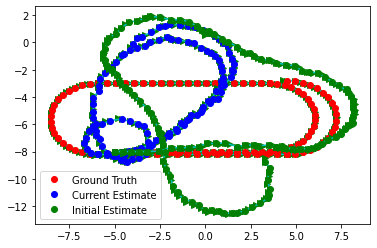

Iteration: 74
Alpha: 3.552713678800501e-15
Error: 9.664859


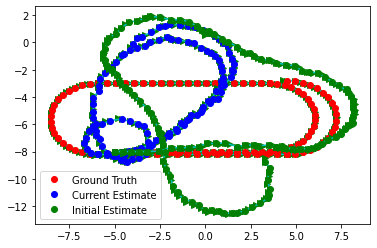

Iteration: 75
Alpha: 1.7763568394002505e-15
Error: 9.664853


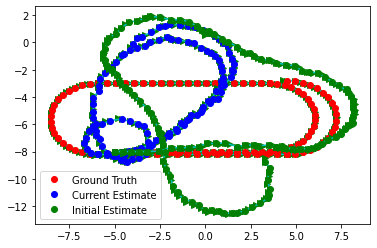

Iteration: 76
Alpha: 8.881784197001252e-16
Error: 9.664854


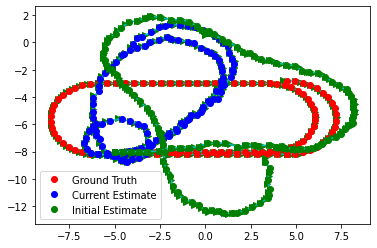

Iteration: 77
Alpha: 4.440892098500626e-16
Error: 9.664856


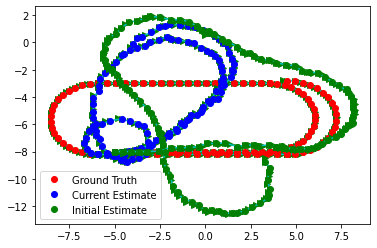

Iteration: 78
Alpha: 2.220446049250313e-16
Error: 9.664859


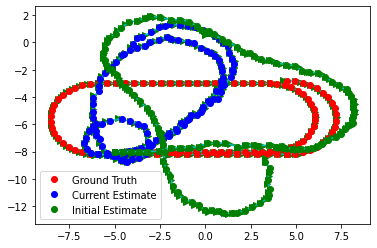

Iteration: 79
Alpha: 1.1102230246251565e-16
Error: 9.664856


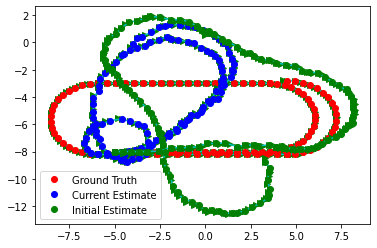

Iteration: 80
Alpha: 5.551115123125783e-17
Error: 9.664854


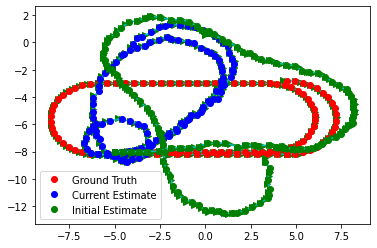

Iteration: 81
Alpha: 2.7755575615628914e-17
Error: 9.664857


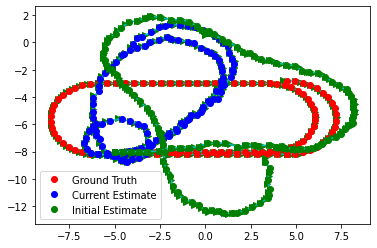

Iteration: 82
Alpha: 1.3877787807814457e-17
Error: 9.664853


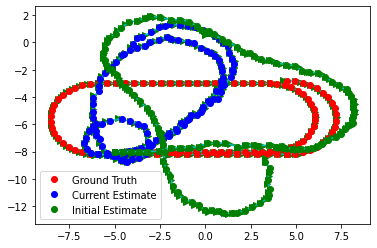

Iteration: 83
Alpha: 6.938893903907228e-18
Error: 9.664854


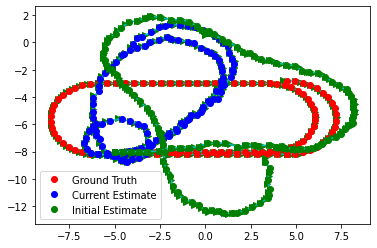

Iteration: 84
Alpha: 3.469446951953614e-18
Error: 9.664855


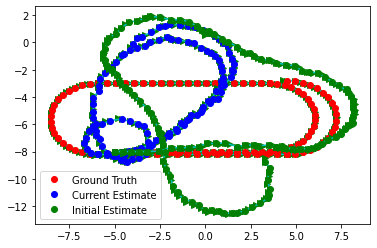

Iteration: 85
Alpha: 1.734723475976807e-18
Error: 9.664861


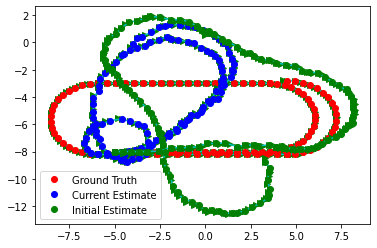

Iteration: 86
Alpha: 8.673617379884035e-19
Error: 9.664859


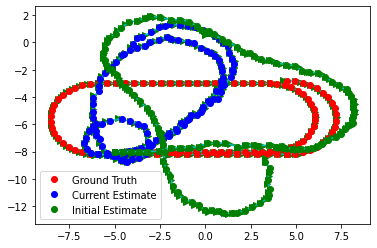

Iteration: 87
Alpha: 4.336808689942018e-19
Error: 9.664853


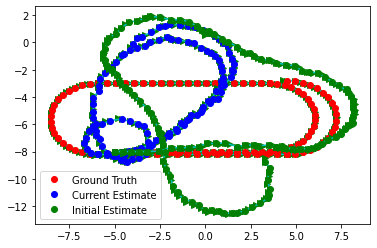

Iteration: 88
Alpha: 2.168404344971009e-19
Error: 9.664855


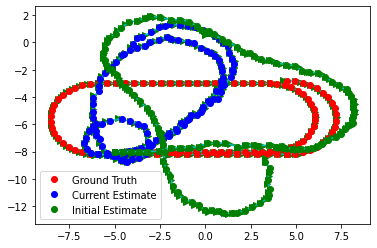

Iteration: 89
Alpha: 1.0842021724855044e-19
Error: 9.664856


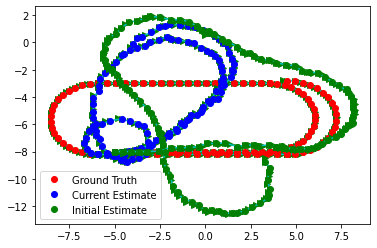

Iteration: 90
Alpha: 5.421010862427522e-20
Error: 9.664861


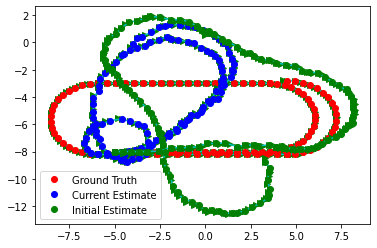

Iteration: 91
Alpha: 2.710505431213761e-20
Error: 9.664859


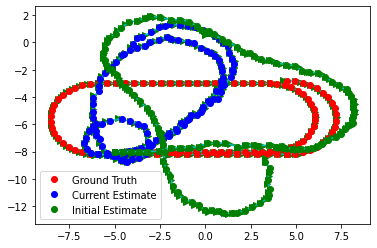

Iteration: 92
Alpha: 1.3552527156068805e-20
Error: 9.664859


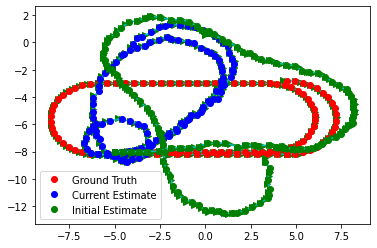

Iteration: 93
Alpha: 6.776263578034403e-21
Error: 9.664858


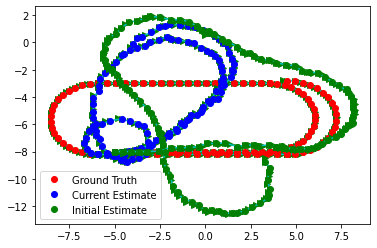

Iteration: 94
Alpha: 3.3881317890172014e-21
Error: 9.664853


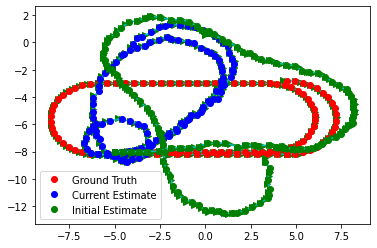

Iteration: 95
Alpha: 1.6940658945086007e-21
Error: 9.664859


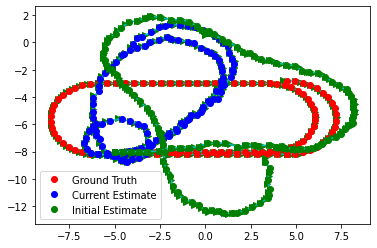

Iteration: 96
Alpha: 8.470329472543003e-22
Error: 9.664854


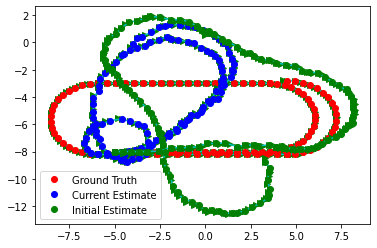

Iteration: 97
Alpha: 4.235164736271502e-22
Error: 9.664851


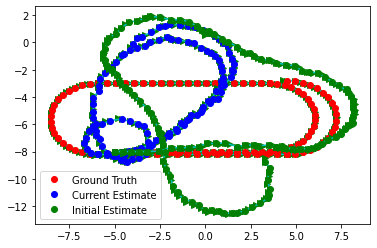

Iteration: 98
Alpha: 2.117582368135751e-22
Error: 9.664854


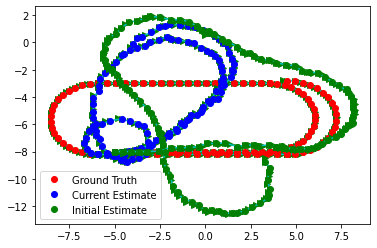

Iteration: 99
Alpha: 1.0587911840678754e-22
Error: 9.664859


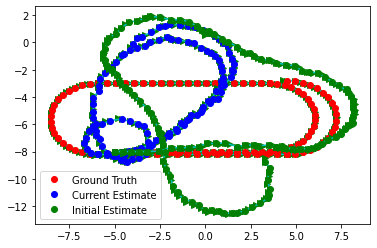

In [7]:
def optimize(poses, edges, anchor, alpha, convergence):
    print("Alpha is " + str(alpha))
    alpha = 1
    weights = compute_information_matrix(edges, weight_odometry, weight_loop_closure, weight_anchor)
    prevPoses = copy.deepcopy(poses)
    currPoses = None
    error = error_func(poses, edges, anchor, weights)
    curr_iter = 1
    print("Initial")
    print("Error:", error)
    draw(actVals[0], actVals[1], actVals[2])
    draw(poses[:,0], poses[:,1], poses[:,2], label="Initial Estimate")
    plt.legend()
    plt.show()
    num_iters = 100
    
    for curr_iter in range(2, num_iters):
    # while(error >= convergence):
        print("Iteration:",curr_iter)
        print("Alpha:",alpha)
        currPoses = prevPoses + calc_step(prevPoses, edges, weights, alpha, anchor)
        prevError = error
        error = error_func(currPoses, edges, anchor, weights)
        if(error > prevError and error-prevError>1):
            alpha *= 2
        else:
            alpha /= 2

        
        print("Error:",error)

        draw(actVals[0], actVals[1], actVals[2])
        draw(currPoses[:,0], currPoses[:,1], currPoses[:,2], label="Current Estimate")
        draw(poses[:,0], poses[:,1], poses[:,2], label="Initial Estimate")

        plt.legend()
        plt.show()
        if jnp.linalg.norm(currPoses - prevPoses) < 1e-6:
            break

        prevPoses = currPoses
        # curr_iter += 1
    
    return currPoses

finPoses = optimize(poses, vals, anchor, 1, 40)


### Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

The Jacobian helps to estimate how small changes in poses affect the residual error (the difference between predicted and observed values) of our optimization problem. The diagonal line signifies that the poses are connected to themselves (identity transformation) while off-diagonal elements capture the dependencies between poses due to constraints.

## Answer:

Consider an edge between `i` and `j`. We estimate

$$x_{j} = x_{i} + \Delta x_{i, j} \cos (\theta_{i}) - \Delta y_{i, j} \sin(\theta_{i})$$

$$y_{j} = y_{i} + \Delta y_{i, j} \cos(\theta_{i}) + \Delta x_{i, j} \sin (\theta_{i})$$


$$\theta_{j} = \theta_{i} + \Delta \theta_{i}$$


and find the difference between this estimated pose and actual pose of `j`th vertex. 
For odometric constraints, `j = i + 1`, but for loop closure constraints that may not be true. The residual has shape $(420, )$. 

For the shape of the Residual:

Anchor Constraints: There will be three residual values for the anchor constraints ($x$ , $y$ , and $\theta$). So, the total number of residual values for anchor constraints is 3.

Loop Closure Constraints: Each loop closure constraint introduces three residual values ($x$ , $y$ , and $\theta$).

Odometry Constraints: Each odometry constraint also introduces three residual values ($x$ , $y$ , and $\theta$). 

Number of edges = Loop closure edges $+$ odometry (adjacent vertex) edges.

Hence the overall shape of the residual will be $3 \times $ (number of edges) $+$ 3. This is a 1D array with the total number of residual values. In our case number of edges = 139.

$\therefore$ <b>Residual shape</b> = $3 \times (139) + 3 = 420.$ It is $(420,)$.

For the shape of the Jacobian: 

The number of rows will be $3 \times $ (number of constraints) = $3 \times $ (number of edges) $+$ 3 = $420$.

The number of columns will be $3 \times $ (number of vertices) = $360$.

$\therefore$ <b>Jacobian shape</b> is $(420, 360)$.

The optimization of the trajectory varies greatly with changes in hyperparameters and intial estimates. 
The initial trajectory being fixed, we tried different values of damping factors and information values (present in the information matrix). The effect of the information values present was much more significant, and we kept the damping factor fixed as 1. On experimenting with different values of information, we see that

1. The given values of 500, 700, 1000 produced an error of about 2841.536 in 33 iterations, which is quite high.
2. Values taken as 30, 1100 and 1300 produced an error of about 88 in 50 iterations which is still above the required value of 40.
3. Final values taken as 10, 1000, 1200 produced an error < 40 in around 10-13 iterations and final error of about 9.66 after 99 interations which satisfies our rquirements.

We thus obtained a minimum error of 9.66 as calculated by the given method. The trajectory obtained is not the same as the actual trajectory since it seems tilted instead of horizontal, but to a great extent has achieved an oval shape as expected. We can also see that towards the end, the optimised trajectory curves anticlockwise along the same oval which is also seen in the actual trajectory (part of loop closure).

### Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [7]:
def writeFin(poses, loopClosures, fileName):
    f = open(fileName, "w+")
    inf_values = "500.0 0.0 0.0 500.0 0.0 500.0"
    loop_inf = "700.0 0.0 0.0 700.0 0.0 700.0"
    edges = []
    for i in range(len(poses)):
        f.write("VERTEX_SE2 " + str(i) + " " + str(poses[i][0]) + " " + str(poses[i][1]) + " " + str(poses[i][2]) + "\n")
        if(i>0):
            edges.append("EDGE_SE2 " + str(i-1) + " " + str(i) + " " + str(poses[i][0] - poses[i-1][0]) + " " + str(poses[i][1] - poses[i-1][1]) + " " + str(poses[i][2] - poses[i-1][2]) + " " + inf_values + "\n")
    
    for i in edges:
        f.write(i)

    f.write("FIX 0\n")

    for i in range(len(loopClosures[0])):
        f.write("EDGE_SE2 " + str(loopClosures[0][i]) + " " + str(loopClosures[1][i]) + " " + str(loopClosures[2][i]) + " " + str(loopClosures[3][i]) + " " + str(loopClosures[4][i]) + " " + loop_inf + "\n")
    
    f.close()


NameError: name 'finPoses' is not defined

In [6]:
writeFin(poses, loopClosures, "../data/unOpt.g2o")

NameError: name 'writeFin' is not defined